In [1]:
# Učitaj osnovne biblioteke...
import scipy as sp
import sklearn
import itertools
import cv2
import numpy as np

import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
def preprocess_image(image, max_width=640, max_height = 480):
    factor = 1
    if image.shape[0]>max_height:
        factor = max_height/float(image.shape[0])
    if image.shape[1]>max_width:
        f2 = max_width/float(image.shape[1])
        factor = f2 if f2 <factor else factor
    resized = cv2.resize(image,(0,0),fx=factor,fy=factor,interpolation=cv2.INTER_CUBIC) if factor <1 else image
    gray = cv2.cvtColor(resized,cv2.COLOR_BGR2GRAY)
    return resized,gray

In [15]:
def symmetry_score_for_pixel(scan_line, index, width, kernel):
    left = scan_line[index-width:index].astype(float)
    right = np.flipud(scan_line[index:index+width]).astype(float)
    diff = np.abs(left - right)
    return diff.dot(kernel)

In [16]:
def symmetry_scores_on_line(whole_image, height_index=400, width = 100):
    scan_line = whole_image[height_index,:]
    kernel = cv2.getGaussianKernel(width*2,0)[width:]*2
    X = range(width,len(scan_line)-width)
    return np.squeeze(np.array([symmetry_score_for_pixel(scan_line,index,width,kernel) for index in X]))

In [17]:
def symmetry_scores_map(image,width):#,verbose=False):
    img = np.zeros(image.shape[1] - width*2)
    for num in xrange(0,image.shape[0]):
        results = symmetry_scores_on_line(image,num,width)
        img = np.vstack((img,results))
    img = img.astype(np.float32)
    padding = np.zeros((img.shape[0],width))
    return np.hstack((padding,img,padding))[1:]#[:,w:img.shape[1]-w]


In [18]:
sigmas = logspace(0,10,11,base=np.sqrt(2))
print sigmas

[  1.           1.41421356   2.           2.82842712   4.           5.65685425
   8.          11.3137085   16.          22.627417    32.        ]


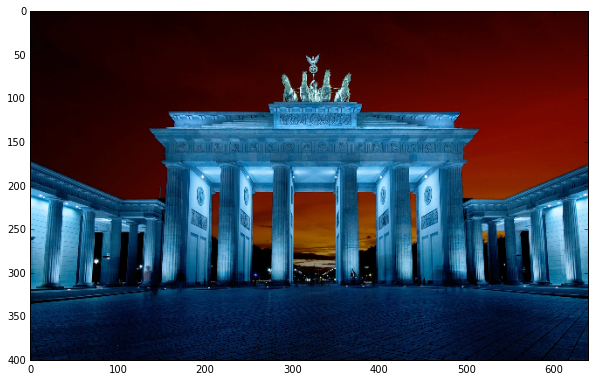

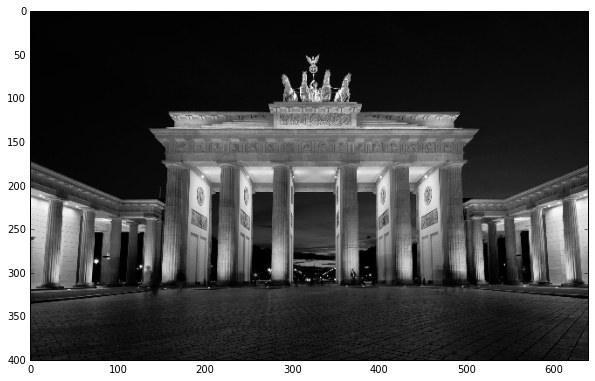

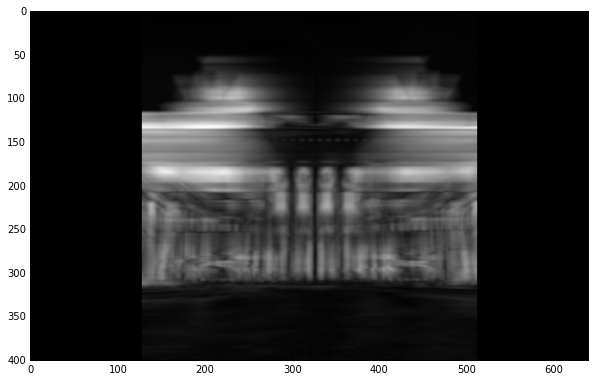

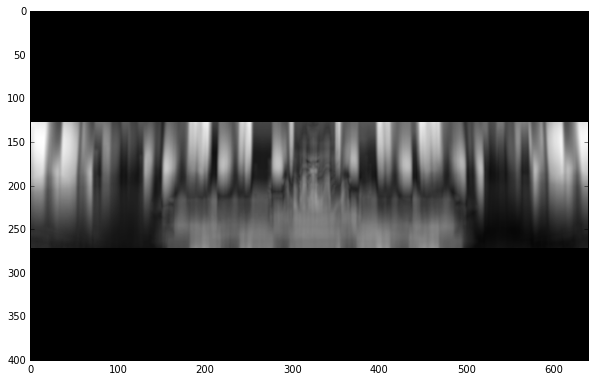

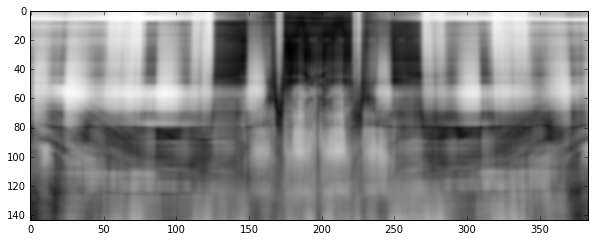

(144, 384)
(144, 384)


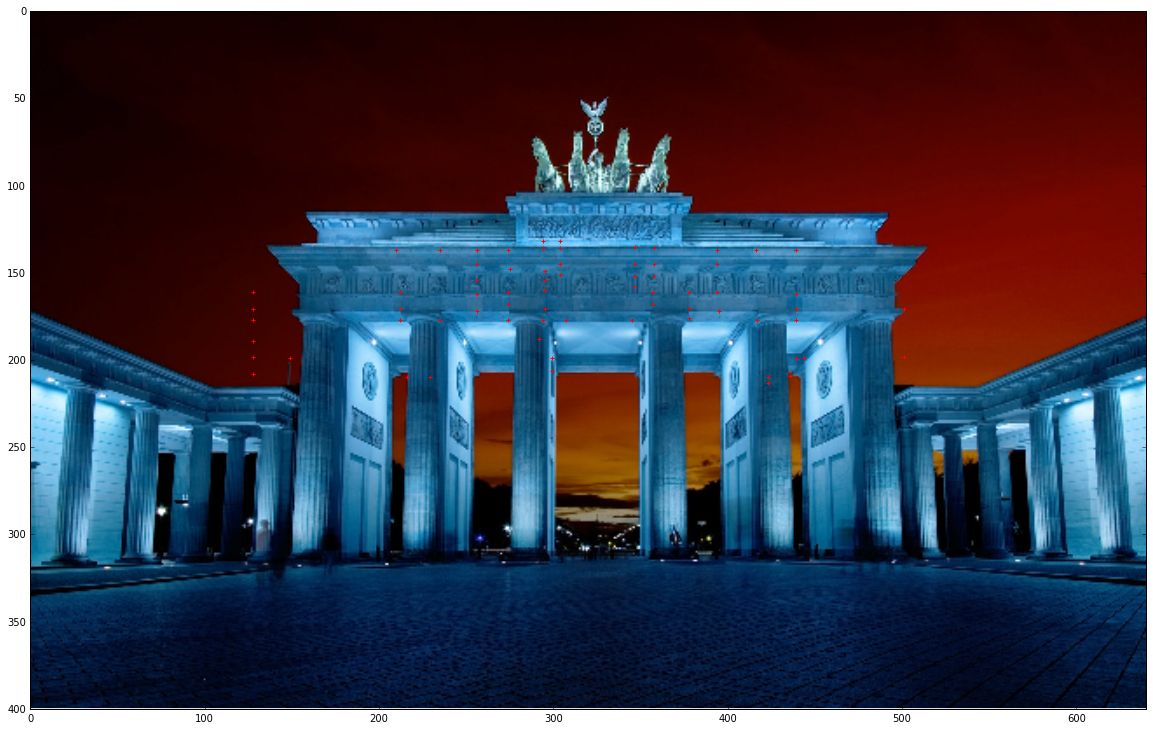

In [21]:
bgr_image = cv2.imread('tor2.jpg')
bgr_image, gray_image = preprocess_image(bgr_image)

def pretty_show(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap='gray')
    plt.show()

blured_gray_image = cv2.GaussianBlur(gray_image,sigmaX=0,ksize=(5,5)) 

width = 128
sym_map_horizontal = symmetry_scores_map(blured_gray_image,width)
#pretty_show(sym_map_horizontal)

#dog_maps_mult_horizontal = calculate_dog_maps_mult(sym_map_horizontal,sigmas)
sym_map_vertical = symmetry_scores_map(blured_gray_image.T,width)
#dog_maps_mult_vertical = calculate_dog_maps_mult(sym_map_vertical,sigmas)
pretty_show(bgr_image)
pretty_show(gray_image)

pretty_show(sym_map_horizontal)
pretty_show(sym_map_vertical.T)

#print sym_map_horizontal


#plt.figure(figsize=(20,20))
#plt.subplot(121),plt.imshow(sym_map_horizontal,cmap='gray')
#plt.subplot(122),plt.imshow(sym_map_vertical.T,cmap='gray')
#plt.show()

#sym_map_horizontal[sym_map_horizontal>25]=512
#sym_map_vertical[sym_map_vertical>25]=512



worst_case_h = np.max(sym_map_horizontal)

worst_case_v = np.max(sym_map_vertical)

suma_sumarum = (worst_case_h - sym_map_horizontal)*(worst_case_v-sym_map_vertical.T)
#suma_sumarum = (worst_case_v - sym_map_vertical.T)*(worst_case_v-sym_map_vertical.T)
#suma_sumarum = (worst_case_h - sym_map_horizontal)#*(worst_case_h-sym_map_horizontal)

suma_sumarum = suma_sumarum[width:-width,width:-width]
suma_sumarum_tw = np.max(suma_sumarum)- suma_sumarum

pretty_show(suma_sumarum_tw)

suma_sumarum_tw = suma_sumarum_tw.astype(np.float32)
kernel_size1= 16-1
gauss1= cv2.GaussianBlur(suma_sumarum_tw,sigmaX=0,ksize=(kernel_size1,kernel_size1)) 
kernel_size2= kernel_size1/2
gauss2= cv2.GaussianBlur(suma_sumarum_tw,sigmaX=0,ksize=(kernel_size2,kernel_size2)) 
suma_sumarum_tw =gauss1-gauss2# cv2.Sobel(suma_sumarum_tw,cv2.CV_32F,2,0,ksize=kernel_size)

#pretty_show(suma_sumarum)

print suma_sumarum_tw.shape

suma_sumarum_tw[suma_sumarum_tw<0] = 0
suma_sumarum_tw[suma_sumarum_tw<np.max(suma_sumarum_tw)*0.5] = 0

print suma_sumarum_tw.shape

neighborhood_size = 5
threshold = 0

data = suma_sumarum_tw

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))
#xy2 = []
#for y,x in xy:
#    if sym_map_horizontal[y+width,x+width]>60 and sym_map_vertical[x+width,y+width]>60:
#        xy2.append((y,x))
#xy = np.array(xy2)
#print xy
#plt.figure(figsize=(20,20))
#plt.subplot(121),plt.imshow(bgr_image,cmap='gray')
#plt.subplot(122)
#plt.scatter(xy[:, 1], xy[:, 0],marker='+',c='r')

#plt.imshow(suma_sumarum_tw,cmap='gray')
#plt.show()


plt.figure(figsize=(20,20))
plt.axis([0,gray_image.shape[1],gray_image.shape[0],0])
plt.imshow(bgr_image)


plt.scatter(xy[:, 1]+width, xy[:, 0]+width,marker='+',c='r')
plt.show()

#for a,b in zip(dog_maps_mult_horizontal[1:],dog_maps_mult_vertical[1:]):
#    
#    plt.figure(figsize=(20,20))
#    plt.subplot(121),plt.imshow(a,cmap='gray')   
#    plt.subplot(122),plt.imshow(b.T,cmap='gray')
#    plt.show()

#    suma_sumarum+=a*b.T

#pretty_show(suma_sumarum)


(352, 240)
(352, 240)


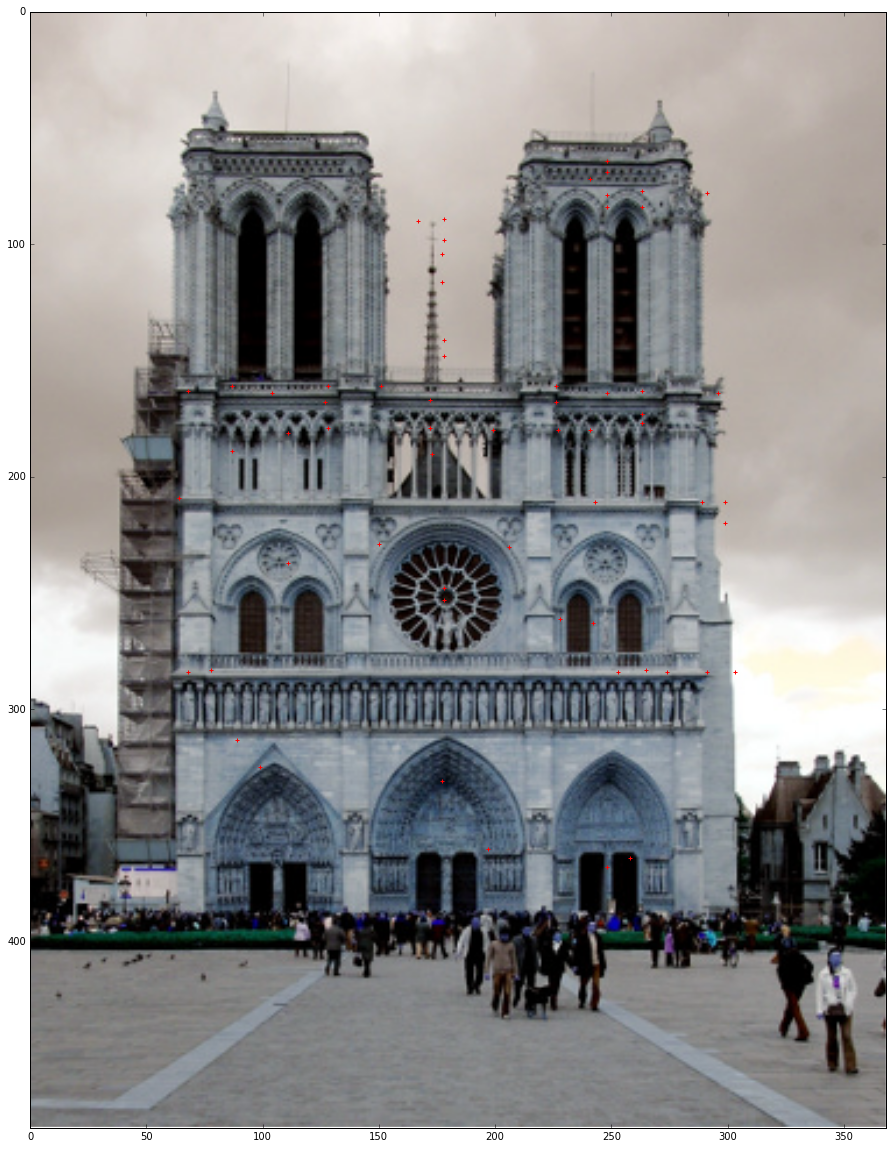

In [13]:

bgr_image = cv2.imread('nd2.jpg')

bgr_image, gray_image = preprocess_image(bgr_image)




def pretty_show(img):
    plt.figure(figsize=(20,20))
    plt.imshow(img,cmap='gray')
    plt.show()

#pretty_show(sym_map)

blured_gray_image = cv2.GaussianBlur(gray_image,sigmaX=0,ksize=(5,5)) 

width = 64
sym_map_horizontal = symmetry_scores_map(blured_gray_image,width)
#dog_maps_mult_horizontal = calculate_dog_maps_mult(sym_map_horizontal,sigmas)
sym_map_vertical = symmetry_scores_map(blured_gray_image.T,width)
#dog_maps_mult_vertical = calculate_dog_maps_mult(sym_map_vertical,sigmas)
#pretty_show(bgr_image)
#pretty_show(sym_map_horizontal)
#pretty_show(sym_map_vertical.T)

#print sym_map_horizontal


#plt.figure(figsize=(20,20))
#plt.subplot(121),plt.imshow(sym_map_horizontal,cmap='gray')
#plt.subplot(122),plt.imshow(sym_map_vertical.T,cmap='gray')
#plt.show()

#sym_map_horizontal[sym_map_horizontal>25]=512
#sym_map_vertical[sym_map_vertical>25]=512



worst_case_h = np.max(sym_map_horizontal)

worst_case_v = np.max(sym_map_vertical)

suma_sumarum = (worst_case_h - sym_map_horizontal)*(worst_case_v-sym_map_vertical.T)
#suma_sumarum = (worst_case_v - sym_map_vertical.T)*(worst_case_v-sym_map_vertical.T)
#suma_sumarum = (worst_case_h - sym_map_horizontal)#*(worst_case_h-sym_map_horizontal)

suma_sumarum = suma_sumarum[width:-width,width:-width]
suma_sumarum_tw = np.max(suma_sumarum)- suma_sumarum

#pretty_show(suma_sumarum_tw)

suma_sumarum_tw = suma_sumarum_tw.astype(np.float32)
kernel_size1= 16-1
gauss1= cv2.GaussianBlur(suma_sumarum_tw,sigmaX=0,ksize=(kernel_size1,kernel_size1)) 
kernel_size2= kernel_size1/2
gauss2= cv2.GaussianBlur(suma_sumarum_tw,sigmaX=0,ksize=(kernel_size2,kernel_size2)) 
suma_sumarum_tw =gauss1-gauss2# cv2.Sobel(suma_sumarum_tw,cv2.CV_32F,2,0,ksize=kernel_size)

#pretty_show(suma_sumarum)

print suma_sumarum_tw.shape

suma_sumarum_tw[suma_sumarum_tw<0] = 0
suma_sumarum_tw[suma_sumarum_tw<np.max(suma_sumarum_tw)*0.5] = 0

print suma_sumarum_tw.shape

neighborhood_size = 5
threshold = 0

data = suma_sumarum_tw

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))
#xy2 = []
#for y,x in xy:
#    if sym_map_horizontal[y+width,x+width]>60 and sym_map_vertical[x+width,y+width]>60:
#        xy2.append((y,x))
#xy = np.array(xy2)
#print xy
#plt.figure(figsize=(20,20))
#plt.subplot(121),plt.imshow(bgr_image,cmap='gray')
#plt.subplot(122)
#plt.scatter(xy[:, 1], xy[:, 0],marker='+',c='r')

#plt.imshow(suma_sumarum_tw,cmap='gray')
#plt.show()


plt.figure(figsize=(20,20))
plt.axis([0,gray_image.shape[1],gray_image.shape[0],0])
plt.imshow(bgr_image)


plt.scatter(xy[:, 1]+width, xy[:, 0]+width,marker='+',c='r')
plt.show()

#for a,b in zip(dog_maps_mult_horizontal[1:],dog_maps_mult_vertical[1:]):
#    
#    plt.figure(figsize=(20,20))
#    plt.subplot(121),plt.imshow(a,cmap='gray')   
#    plt.subplot(122),plt.imshow(b.T,cmap='gray')
#    plt.show()

#    suma_sumarum+=a*b.T

#pretty_show(suma_sumarum)

